In [3]:
# Import libs
import sys
import matplotlib.pyplot as plt
from docplex.mp.model import Model
from docplex.util.environment import get_environment
from docplex.mp.relax_linear import LinearRelaxer
import itertools

try:
    import docplex.mp
except:
    raise Exception('Please install docplex. See https://pypi.org/project/docplex/')

[['R', 'M', 'O', 'N'], ['RR', 'RM', 'RO', 'RN', 'MR', 'MM', 'MO', 'MN', 'OR', 'OM', 'OO', 'ON', 'NR', 'NM', 'NO', 'NN'], ['RRR', 'RRM', 'RRO', 'RRN', 'RMR', 'RMM', 'RMO', 'RMN', 'ROR', 'ROM', 'ROO', 'RON', 'RNR', 'RNM', 'RNO', 'RNN', 'MRR', 'MRM', 'MRO', 'MRN', 'MMR', 'MMM', 'MMO', 'MMN', 'MOR', 'MOM', 'MOO', 'MON', 'MNR', 'MNM', 'MNO', 'MNN', 'ORR', 'ORM', 'ORO', 'ORN', 'OMR', 'OMM', 'OMO', 'OMN', 'OOR', 'OOM', 'OOO', 'OON', 'ONR', 'ONM', 'ONO', 'ONN', 'NRR', 'NRM', 'NRO', 'NRN', 'NMR', 'NMM', 'NMO', 'NMN', 'NOR', 'NOM', 'NOO', 'NON', 'NNR', 'NNM', 'NNO', 'NNN']]
Model: Ejercicio 2.2: Asignación de tareas
 - number of variables: 84
   - binary=0, integer=0, continuous=84
 - number of constraints: 15
   - linear=15
 - parameters: defaults
 - objective: none
 - problem type is: LP
* Production model solved with objective: 146.052
Day 1
---------------
R: 1.667
M: 0.536
O: 1.250
N: 5.548
Day 2
---------------
R: 3.788
M: 0.451
O: 0.000
N: 4.761
Day 3
---------------
R: 2.652
M: 0.464
O: 

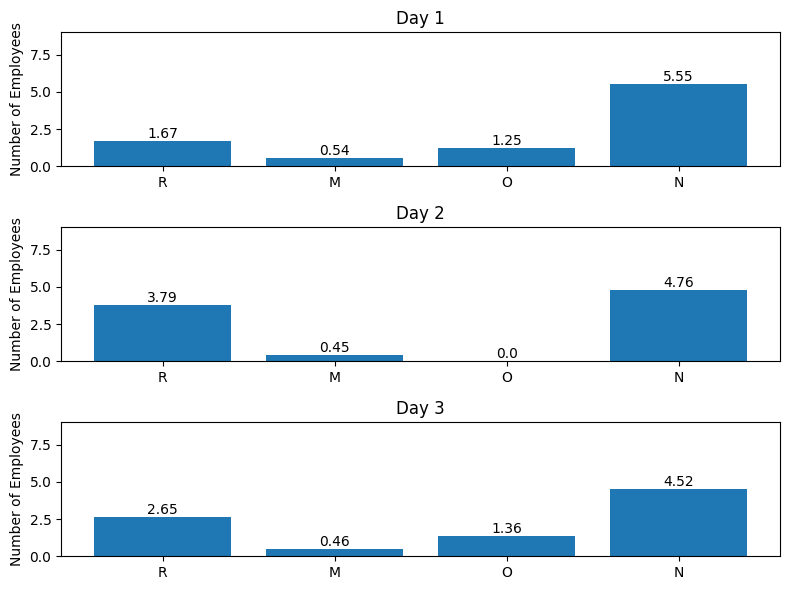

In [4]:
# Import libs
import sys
import matplotlib.pyplot as plt
from docplex.mp.model import Model
from docplex.util.environment import get_environment
from docplex.mp.relax_linear import LinearRelaxer
import itertools

try:
    import docplex.mp
except:
    raise Exception('Please install docplex. See https://pypi.org/project/docplex/')
def gen_tasks(days, tasks):
    task_day = []

    for i in range(days):
        # Generar combinaciones de longitud i + 1
        combinaciones = [''.join(comb) for comb in itertools.product(tasks, repeat=i + 1)]
        task_day.append(combinaciones)
    return task_day

DAYS = 3 # 3
TOTAL_EMPLOYEES = 9 #18
turno_hs = 8 # 8
eficiencia_motivacion = 1.1 # 1.1
pago_turno = 12 #12

# Declaracion de las tareas
initial_tasks = ["R", "M", "O", "N"]
tasks_day = gen_tasks(DAYS, initial_tasks)

# Eficiencia base por tarea
efficiency = {"R": 15, "O": 30, "M": 35, "N": 0}

# Criterio de aumento de eficiencia
criteria = lambda day, a: day == 0 or a[day] == a[day - 1]

# Objetivos diarios
# A:450 y C:360 para prueba
A = 200
C = 360
day_obj = {
    "R": {0: A,     1: 500,     2: 350},
    "O": {0: 300,   1: 0,       2: C},
    "M": {0: 150,   1: 139,     2: 143},
    "N": {0: 0,     1: 0,       2: 0}
}

# Crea el modelo
def create_model():
    mdl = Model(name="Ejercicio 2.2: Asignación de tareas")

    produccion_vars = {}
    for day_tasks in tasks_day:
        for task in day_tasks:
            produccion_vars[task] = mdl.continuous_var(name="x_" + task)

    # --- Restricciones ---
    for task, days in day_obj.items():
        for day, target in days.items():
            # Crear una restricción para cumplir con los objetivos de producción diaria
            mdl.add_constraint(
                mdl.sum(
                    (produccion_vars[comb] * turno_hs *
                    (efficiency[task] if criteria(day, comb)
                     else efficiency[task] * eficiencia_motivacion)
                     )
                    for comb in tasks_day[day] if comb[-1] == task
                ) >= target,
                ctname=f"Objetivo_{task}_dia_{day + 1}"
            )
    
    for dia in range(DAYS):  # Para cada día
        mdl.add_constraint(
            mdl.sum(
                produccion_vars[tarea]
                for tarea in tasks_day[dia]
            ) == TOTAL_EMPLOYEES,
            ctname=f"Empleados_totales_dia_{dia}"
        )

    # --- print information ---
    mdl.print_information()
    total_employees = mdl.sum(produccion_vars[e] for e in produccion_vars.keys() if e[-1] != 'N' ) * pago_turno

    # --- set the objective ---
    mdl.minimize(total_employees)

    return mdl, produccion_vars

# Solve the model
def solve_model(mdl):
    solution = mdl.solve()

    if not solution:
        print("Model cannot be solved.")
        sys.exit(1)

    with get_environment().get_output_stream("solution.json") as fp:
                mdl.solution.export(fp, "json")

    obj = mdl.objective_value

    print("* Production model solved with objective: {:g}".format(obj))

    employees_per_day = []
    lenght = 0
    for day in tasks_day:
        lenght += 1
        print(f"Day {lenght}")
        print("-"*15)
        sum_day = dict()
        for p in day:
            sum_day[p[-1]] = sum_day.get(p[-1], 0) + produccion_vars[p].solution_value
        employees_per_day.append(sum_day)
        for task, sum in sum_day.items():
            print(f"{task}: {sum:.3f}")

    save_to_txt(employees_per_day)


    # Graficar la distribución de empleados para cada día
    graphs = True
    if graphs: plot_employees_per_day(employees_per_day)


# Función para graficar los resultados usando matplotlib
def plot_employees_per_day(employees_per_day):
    days = len(employees_per_day)
    tasks = list(employees_per_day[0].keys())

    fig, axes = plt.subplots(nrows=days, ncols=1, figsize=(8, 6))

    if days == 1:
        axes = [axes]

    for i in range(days):
        ax = axes[i]
        empleados = [employees_per_day[i].get(tarea, 0) for tarea in tasks]
        bars = ax.bar(tasks, empleados)
        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), 
                    ha='center', va='bottom')

        ax.set_title(f"Day {i+1}")
        ax.set_ylabel("Number of Employees")
        ax.set_ylim(0, TOTAL_EMPLOYEES)

    plt.tight_layout()
    plt.show()

# Create the model with constraints and objective
mdl, produccion_vars = create_model()

# Solve the model
solve_model(mdl)